In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *
from matplotlib import gridspec
import h5py
import math
import numpy as np
import matplotlib.ticker as plticker
import sys
import os
import qutip as q
from pylab import *
import gc
import pprint

folder = os.getcwd()
sys.path.insert(0,os.path.join(folder,'functions'))
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

mpl.rcParams['figure.figsize'] = (6.0, 4.0)  
mpl.rcParams['font.size'] = 14  
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.subplot.bottom'] = .1  

# Auxiliary functions
+ Plot of the Wigner function
+ Parametrize the qubit on the Bloch sphere

In [2]:

xvec = np.linspace(-10, 10, 100)
#outputs the wigner function of a given state
def plot_wig(rho, fig, xvec=xvec):
    '''Plots the Wigner distribution
       Input: rho= density matrix of the state (Qutip Qobj)
              fig= label for the output figure 
              xvec= mesh of the plot given by a numpy array (set by default from [-7, 7]) 
       Output: Plot of the Wigner distribution with insets representing the marginal proability distributions of the X and P variables of the pointer state       
    '''
    plt.figure(fig);
    plt.clf()
    gs = gridspec.GridSpec(2, 2, width_ratios=[1., .25], height_ratios=[.25, 1.])
    gs.update(right=.98)
    ax = plt.subplot(gs[2])
    axv = plt.subplot(gs[3], sharey=ax)
    axh = plt.subplot(gs[0], sharex=ax)
    plt.subplots_adjust(hspace=.02, wspace=.02)
    plt.setp(axh.get_xticklabels(), visible=False)
    plt.setp(axv.get_yticklabels(), visible=False)
    Wig = q.wigner(rho, xvec, xvec, g=2)
    Wig = Wig / (np.sum(Wig) * (-xvec[0] + xvec[1]))
    scale = np.max(np.abs(Wig));
    ax.contourf(xvec, xvec, Wig, levels=np.linspace(-scale, scale, 501),cmap='RdBu_r',vmax=1 * scale, vmin=-1 * scale)
    ax.grid(False)
    axh.grid(False)
    axv.grid(False)
    axh.plot(xvec, np.sum(Wig, axis=0), 'r', zorder=+10, label='Sim.')
    axv.plot(np.sum(Wig, axis=1), xvec, 'r', zorder=+10)
    axh.set_xlim(xvec.min(), xvec.max())
    axv.set_ylim(xvec.min(), xvec.max())
    ax.set_aspect('equal')
    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$p$')
    axh.set_ylabel(r'P$(q)$')
    axv.set_xlabel(r'P$(p)$')
   

 #define the state
def state(t,p,l,r):
    ''' Define the pre- or post-selected state in the case of three qubits (three particles and two boxes)
        Inputs:t=polar angle
               p=azimuthal angle
               l= 0 in computational basis (Qutip Qobj)
               r= 1 in coputational basis (Qutip Qobj)
        Output:tensor product of three qubits (Qutip Qobj)
    '''
    s=tensor(np.cos(t/2)*l+np.exp(1.j*p)*np.sin(t/2)*r,np.cos(t/2)*l+np.exp(1.j*p)*np.sin(t/2)*r,np.cos(t/2)*l+np.exp(1.j*p)*np.sin(t/2)*r,np.cos(t/2)*l+np.exp(1.j*p)*np.sin(t/2)*r,np.cos(t/2)*l+np.exp(1.j*p)*np.sin(t/2)*r)
    return s

# Main function for the pigeonhole simulation
+ Plots the Wigner distribution given the given the pre- and post-selected states

In [3]:
def Pigeon(N,ti,tf,pin,pif,sqzparam,pointer,coupl,sdf_t1): 
    '''Function plotting the Wigner distribution given the pre- and post-selected states
       Inputs: N=Dimension of the Hilbert space 
               ti=polar angle of the pre-selected state
               tf=polar angle of the post-selected state
               pin=azimuthal angle of the pre-selected state
               pif=azimuthal angle of the post-selected state
               sqzparam=squeezing parameter expressed in dB
               pointer=choice between coherent "c" and squeezed "s" states
               coupl=coupling constant of the Hamiltonian
               sdf_t1=gate time
       Output: Prints on the screen: -hilbert-schmidt inner product
                                    -the expectation value of the position and momentum operator after the post-selection
                                    -weak value of the observable we are measuring
               Plots the Wigner distribution of the pointer after the post-selection
    '''
    #basis vectors
    l = basis(2,1)
    r = basis(2,0)
    #pre-selected state
    pre=state(ti,pin,l,r)
    #post-selected state
    post=state(tf,pif,l,r)

    #create the possibility of a sqeezed quantum pointer
    #sqeezed state
    sq_op =q.squeeze(N, sqzparam)
    sq_state=q.squeeze(N, sqzparam)*coherent(N, 0)

    #add the quantum pointer
    if pointer == 's':
        #squeezed pointer
        rho0=(tensor(pre,sq_state)*tensor(pre,sq_state).dag()).unit()
    elif pointer == 'c':
        #coherent pointer
        rho0=(tensor(pre,coherent(N, 0))*tensor(pre,coherent(N, 0)).dag()).unit()
    else: raise TypeError('Your pointer type is not correct. Please input "c" for coherent or "s" for squeezed')

    #spin dependent hamiltonian
    ll=tensor(l,l)
    llt=ll*ll.dag()
    rr=tensor(r,r)
    rrt=rr*rr.dag()
    idd=qeye(2)
    #+/- basis measurement
    pl=tensor((l+r)/np.sqrt(2),(l+r)/np.sqrt(2),(l+r)/np.sqrt(2))
    mi=tensor((l-r)/np.sqrt(2),(l-r)/np.sqrt(2),(l-r)/np.sqrt(2))
    pp=pl*pl.dag()
    mm=mi*mi.dag()
    oper=tensor(sigmax(),idd,idd,idd,idd)+tensor(idd,sigmax(),idd,idd,idd)+tensor(idd,idd,sigmax(),idd,idd)+tensor(idd,idd,idd,sigmax(),idd)+tensor(idd,idd,idd,idd,sigmax())
    spindep=tensor(oper,momentum(N))
    #weak measurement protocol
    #a=((tensor(idd,idd,idd,idd,qeye(N))-1.j*coupl*sdf_t1*spindep)*rho0*((tensor(idd,idd,idd,idd,qeye(N))-1.j*coupl*sdf_t1*spindep).dag())).unit()
    a1=((-1.j*coupl*sdf_t1*spindep).expm()*rho0*(-1.j*coupl*sdf_t1*spindep).expm().dag()).unit()
    #dist=(a.dag()*a1).tr()
    #show the trace distance (hilbert-schmidt inner product) of the approximated time propagator and the full time propagator
    #print("The trace distance between the Unitary time propagator and its expansion to the first order is:",dist)

    #final projection and wigner function of the pointer
    d=post*post.dag()
    dd=tensor(d,qeye(N))
    b=(((dd.dag()*a1)).ptrace(5)).unit()
    plot_wig(b, fig='test')
    plt.show()

    #variance of the momentum at the initial time
    if pointer == 's':
        b0=(sq_state*sq_state.dag()).unit()
    elif pointer == 'c':
        b0=(coherent(N, 0)*coherent(N, 0).dag()).unit()
    
    k1=(b0*momentum(N)).tr()
    k2=(b0*momentum(N)*momentum(N)).tr()
    vark=k2-k1*k1
    #prints the expectation value of the position and momentum operator + weak value of the observable we are measuring
    k=(b*momentum(N)).tr()
    print("The expectation value of the momentum operator is:",k)
    print("Im part of the weak value:",k/(2*coupl*sdf_t1*vark))
    p=(b*position(N)).tr()
    print("The expectation value of the position operator is:",p)
    print("Re part of the weak value:",p/(coupl*sdf_t1))
    
    
    saveTo = os.path.join(folder,'presentation')
    savefig(saveTo,dpi=500, bbox_inches='tight')



# Input the simulation parameters and run 

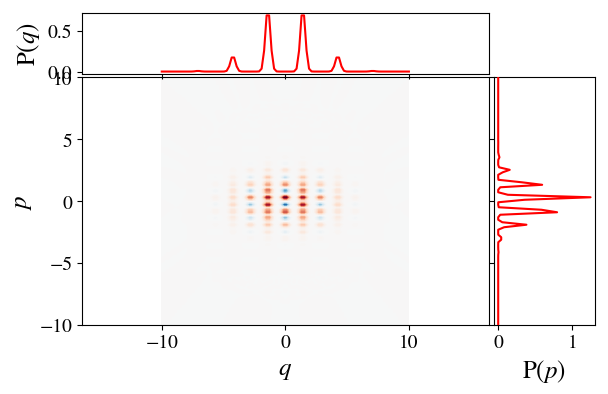

The expectation value of the momentum operator is: (-2.3786273813048656e-05+0j)
Im part of the weak value: (-1.965922308317536e-06+0j)
The expectation value of the position operator is: 8.222208959643429e-06j
Re part of the weak value: 4.1111044798217145e-06j


In [5]:
#dimension of the Hilbert space
N=100

#here i select the initial and the final angles on the bloch sphere
ti=np.pi/2
pin=np.pi/(2)
tf=0
pif=0

#squeezing parameter choosen to be real and expressed in dB 
sqzparam=0.9

#quantum pointer
pointer= 's' # 's' for squeezed and 'c' for coherent

#Hamiltonian parameters
coupl=2
sdf_t1=1

Pigeon(N,ti,tf,pin,pif,sqzparam,pointer,coupl,sdf_t1)

In [38]:
l = basis(2,1)
r = basis(2,0)
coupl=2
sdf_t1=1
tin=np.pi/2
pin=np.pi/2
tout=0
pout=0
inp=(np.cos(tin/2)*l+np.exp(1.j*pin)*np.sin(tin/2)*r)
outp=(np.cos(tout/2)*l+np.exp(1.j*pout)*np.sin(tout/2)*r)
oper1=sigmax()
s=((1.j*np.pi*0.25*oper1).expm()*inp)
print(s,inp,r)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.+1.j]
 [ 0.+0.j]] Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.00000000+0.70710678j]
 [ 0.70710678+0.j        ]] Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 1.]
 [ 0.]]
